<a href="https://colab.research.google.com/github/Tai2970/Accent-Recognition-Project/blob/main/scripts/full_pipeline_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa scikit-learn pandas numpy soundfile
!pip install praat-parselmouth --quiet

In [2]:
from google.colab import files
import os, shutil

# STEP 1: Upload model and scaler
uploaded = files.upload()  # Upload BOTH final_model.pkl and scaler.pkl again

# STEP 2: Ensure 'models' directory exists
os.makedirs("models", exist_ok=True)

# STEP 3: Move uploaded files into 'models' directory WITHOUT renaming
for filename in uploaded:
    shutil.move(filename, os.path.join("models", filename))
    print(f"Saved {filename} to models/")

Saving scaler.pkl to scaler.pkl
Saving final_model.pkl to final_model.pkl
Saved scaler.pkl to models/
Saved final_model.pkl to models/


In [40]:
# Install necessary package
!pip install pydub
!apt-get install ffmpeg -y

# STEP 1: Delete any existing test_samples folder to avoid duplicates
import shutil
shutil.rmtree("data/test_samples", ignore_errors=True)

# STEP 2: Recreate the folder clean
os.makedirs("data/test_samples", exist_ok=True)

# STEP 3: Upload your new audio files
from google.colab import files
uploaded = files.upload()

# STEP 4: Move and convert uploaded files to the 'test_samples' folder
from pydub import AudioSegment

for filename in uploaded:
    file_ext = filename.split('.')[-1].lower()

    # If file is already .wav, move it directly
    if file_ext == "wav":
        shutil.move(filename, f"data/test_samples/{filename}")

    # If file is .mp3 or anything else, convert to .wav
    else:
        sound = AudioSegment.from_file(filename)
        new_filename = filename.rsplit(".", 1)[0] + ".wav"
        sound.export(f"data/test_samples/{new_filename}", format="wav")
        print(f"Converted and saved: {new_filename}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Saving vie_word-list_1993_01.wav to vie_word-list_1993_01.wav


In [39]:
# Main prediction logic

import librosa
import numpy as np
import joblib
import pandas as pd
import parselmouth
import warnings
import time
warnings.filterwarnings("ignore")

# Load trained model and scaler
model = joblib.load("models/final_model.pkl")
scaler = joblib.load("models/scaler.pkl")

# Folder for test files
test_folder = "data/test_samples/"
accent_labels = {0: "American", 1: "British", 2: "Vietnamese"}

# Feature extraction: MFCCs, delta MFCCs, spectral contrast, pitch, formants
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta_mfccs = librosa.feature.delta(mfccs)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    snd = parselmouth.Sound(file_path)
    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_values = pitch_values[pitch_values > 0]
    pitch_mean = np.mean(pitch_values) if len(pitch_values) > 0 else 0

    formant = snd.to_formant_burg()
    num_frames = formant.get_number_of_frames()
    f1, f2, f3 = [], [], []
    for i in range(num_frames):
        t = formant.get_time_from_frame_number(i + 1)
        f1.append(formant.get_value_at_time(1, t) or 0)
        f2.append(formant.get_value_at_time(2, t) or 0)
        f3.append(formant.get_value_at_time(3, t) or 0)

    formant_means = [
        np.mean([v for v in f1 if v > 0]) if f1 else 0,
        np.mean([v for v in f2 if v > 0]) if f2 else 0,
        np.mean([v for v in f3 if v > 0]) if f3 else 0
    ]

    return np.hstack((
        mfccs.mean(axis=1),
        delta_mfccs.mean(axis=1),
        contrast.mean(axis=1),
        [pitch_mean],
        formant_means
    ))

# Predict and display results with inference time
print("Accent Predictions:")
print("-" * 40)

for filename in sorted(os.listdir(test_folder)):
    if filename.endswith(".wav"):
        file_path = os.path.join(test_folder, filename)
        try:
            features = extract_features(file_path).reshape(1, -1)

            # NEW: Apply scaling before prediction
            features_scaled = scaler.transform(features)

            # Start timer
            start_time = time.time()

            prediction = model.predict(features_scaled)[0]

            # End timer
            inference_time = time.time() - start_time

            label = accent_labels[prediction]
            print(f"{filename} ➜ Predicted Accent: {label} (Time: {inference_time:.4f} sec)")
        except Exception as e:
            print(f"{filename} ➜ Error: {e}")


Accent Predictions:
----------------------------------------
OSR_uk_000_0024_8k_British.wav ➜ Predicted Accent: British (Time: 0.0034 sec)


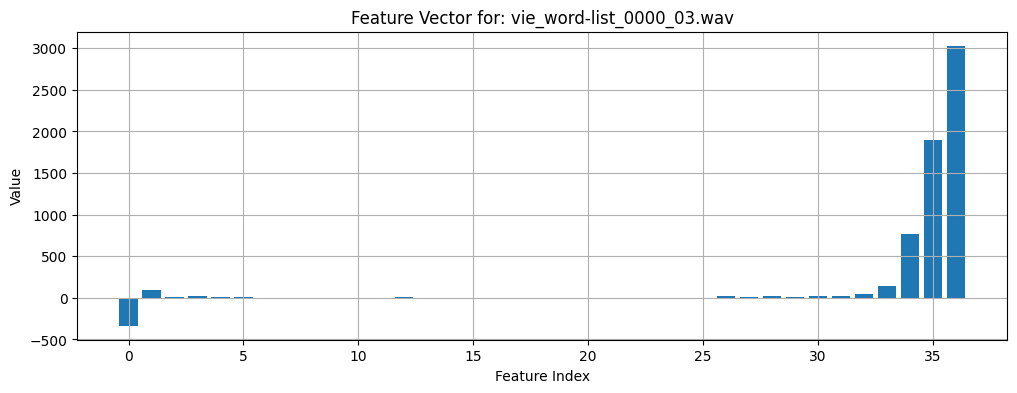

In [5]:
# OPTIONAL: Visualize the features of the last test file
import matplotlib.pyplot as plt

# Reuse the last file processed in the loop
file_to_plot = file_path  # from the previous loop
features = extract_features(file_to_plot)

plt.figure(figsize=(12, 4))
plt.bar(range(len(features)), features)
plt.title(f"Feature Vector for: {os.path.basename(file_to_plot)}")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()